## **Modelando un YSO**
En este proyecto modelamos una estrella joven, (Young Estelar Object), en particular queremos modelar su distrubución de energía espectral (SED) usando la fórmula:  $F_{\nu} = \frac{\cos i}{d^2} \int_{R_{\text{min}}}^{R_{\text{max}}} B_{\nu}(T(r)) \left[ 1 - \exp \left( -\frac{\kappa_{\nu} \Sigma(r)}{\cos i} \right) \right] 2\pi r \, dr$

## Parte 0
Graficamos la SED primero sin correción por el polvo galáctico y luego con su correción

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii


data = ascii.read('aa_tau.txt')   # leemos los datos
longitudes= data['col1']          # medido en micrones  (1E-4 cm)
flujo=data['col2']                # medido en Jy
longitudes_cm= data['col1'] * 1e-4 #ahora en cm
frecuencias = 2.99792e+10 / longitudes_cm   #pasamos la velocidad de la luz a cm/s y usamos nu=c/lambda

#ojo que tenemos flujo en funcion de la longitud de onda y no de la frecuencia
# de modo que el flujo en funcion de la frecuencia nu es:
flujo= flujo*1e-26    #pasamos de Jy a W/m**2

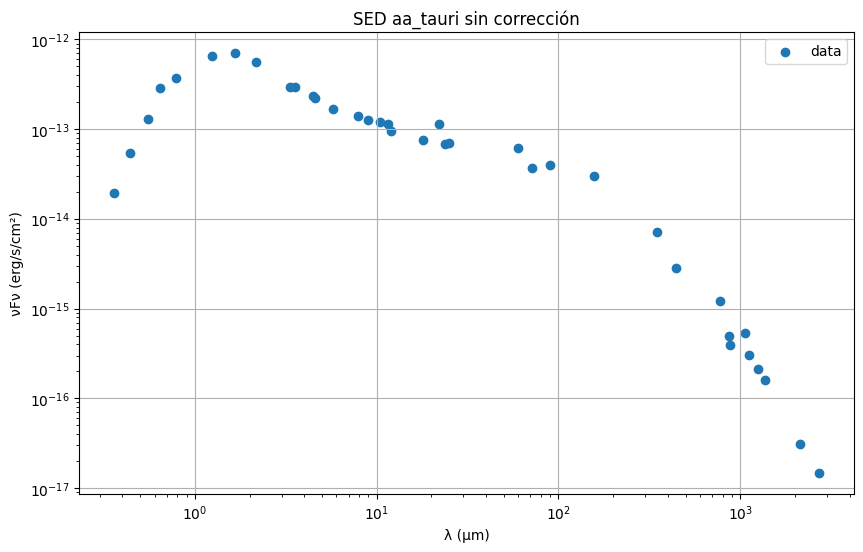

In [2]:
plt.figure(figsize=(10,6))     #graficamos los datos
plt.title('SED aa_tauri sin corrección')
plt.scatter(longitudes,frecuencias*flujo,label= 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('λ (µm)')
plt.ylabel('νFν (erg/s/cm²)')
plt.legend()
plt.grid()
plt.show()

Ahora para corregir por la interferencia del polvo galáctico usamos la ley de Cardelli, Clayton, Mathis (CCM89)

In [3]:
#aplicamos la corrección por polvo galáctico

def ccm89(wavelengths, R_V=3.1, A_v=1.4):
    """
    Ley CCM89 extendida a IR.
    Entrada: longitudes en micrones.
    Salida: A_lambda para cada λ.
    """

    x = 1.0 / wavelengths  # en micrones

    A_lambda = np.zeros_like(wavelengths)

    # CCM válido entre 0.3 < x < 3.3 micrones
    mask_ccm = (x >= 1.1) & (x <= 3.3)
    y = x[mask_ccm] - 1.82

    a = (1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 +
         0.72085*y**4 + 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7)

    b = (1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 -
         0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7)

    k_lambda = np.zeros_like(wavelengths)
    k_lambda[mask_ccm] = a + b / R_V

    # Extensión al IR
    mask_ir = wavelengths > 1.1
    k_lambda[mask_ir] = 0.574 * (wavelengths[mask_ir])**(-1.61) * R_V
    # A_lambda
    A_lambda = A_v * k_lambda / R_V
    return A_lambda

A_lambda=ccm89(longitudes,3.1,1.4)   # le damos el valor 1.4 a A_v
flujo_real = flujo * 10**(0.4*A_lambda)

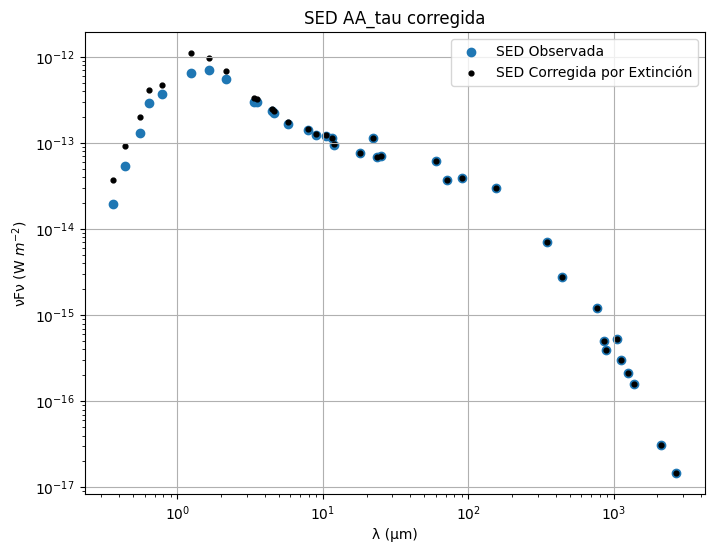

In [4]:
#graficamos la correción
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, frecuencias*flujo, label="SED Observada")
plt.scatter(longitudes, frecuencias*flujo_real, label="SED Corregida por Extinción",color='black',s=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('λ (µm)')
plt.ylabel('νFν (W $m^{-2}$)')
plt.title('SED AA_tau corregida')
plt.legend()
plt.grid(True)
plt.show()

## 1 Modelo inicial
En esta parte se ajusta un modelo haciendo un initial guess de los parámetros que explican la curva

In [5]:
#importamos quad para integrar
from scipy.integrate import quad


#parametros para modelar el disco + la estrella

q = 0.75
r1_au = 1.0
Rmin_au = 0.03
Rmax_au = 100

# Convertimos a cm
au_to_cm = 1.496e13
r1 = r1_au * au_to_cm
Rmin = Rmin_au * au_to_cm
Rmax = Rmax_au * au_to_cm

# Densidad superficial y temperatura base
Σ1 = 100
T1 = 140

# Ángulo de inclinación (en radianes)
i = np.deg2rad(59)

# Distancia a la estrella (convertimos de mas a cm)
paralaje = 7.4254  # en mas obtenido de GAIA archive
d_cm = (1 / (paralaje * 1e-3)) * 3.086e18  # 1 mas = 1e-3 arcsec; 1 pc = 3.086e18 cm

# Opacidades
kappa_o = 10  # cm**2/g
nu0 = 1e12    # Hz
beta = 1.0


In [6]:
#Definimos las funciones que vamos a utilizar
c= 2.99792e+10    #ctes en cgs
kB = 1.38065e-16
h=  6.62606e-27

def B_nu(nu, T):   # función de Planck
    return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))

def T_r(r): # como cambia la temperatura en funcion del radio
    return T1 * (r/r1)**(-q)

def kappa_nu(nu): #opacidad del polvo
    return kappa_o * (nu/nu0)**beta

def Sigma_r(r): # cambio de densidad superficial del disco con el radio
    return Σ1 * (r/r1)**(-1)

# Definimos la integral para obtener el flujo
def integracion (r,nu): #nu es la frecuencia
    T = T_r(r)
    Sigma = Sigma_r(r)
    kappa = kappa_nu(nu)
    tau = kappa * Sigma / np.cos(i)
    return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

# modelo del flujo del disco + estrella
def F_nu_modelo(nu):
    resultado, _ = quad(lambda r: integracion(r, nu), Rmin, Rmax)
    return np.cos(i) / d_cm**2 * resultado  # erg/s/cm²/Hz


<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


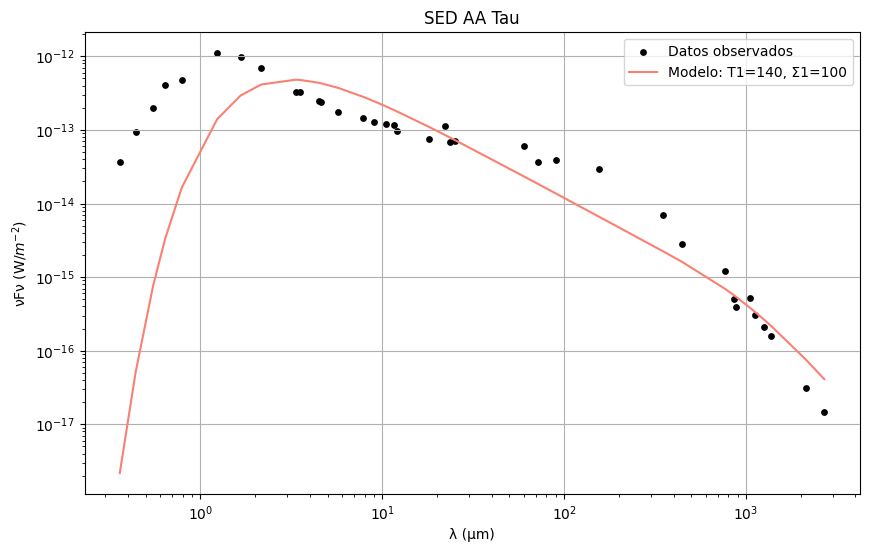

In [7]:
# calcular flujo modelo para cada frecuencia
flujo_modelo_array = np.array([F_nu_modelo(nu) for nu in frecuencias])


nuFnu_modelo= frecuencias*flujo_modelo_array *1e-3 #y lo pasamos a W/m**-2

# graficar datos + modelo
plt.figure(figsize=(10,6))
plt.scatter(longitudes, frecuencias * flujo_real, label='Datos observados',color='black',s=15)
plt.plot(longitudes, nuFnu_modelo, label=f'Modelo: T1={T1}, Σ1={Σ1}', color='salmon')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('λ (μm)')
plt.ylabel('νFν (W/$m^{-2}$)')
plt.title('SED AA Tau')
plt.legend()
plt.grid()
plt.show()


Ahora graficamos la estrella como una curva a parte para tratar de visualizar su contribución

In [8]:
from scipy.constants import sigma  # sigma: constante de Stefan-Boltzmann

#ahora consideramos la estrella aparte
T_star = 4060              # Temperatura efectiva [K]
L_sun = 3.828e26            # Luminosidad solar en W
L_star = 0.87 * L_sun       # Luminosidad de la estrella en W

# Radio estelar usando la relación (Stefan-Boltzmann)
R_star = np.sqrt(L_star / (4.0 * np.pi * sigma * T_star**4)) # en metros
R_star_cm = R_star * 1e2  # en cm

#flujo de la estrella (como cuerpo negro)
def star_flux_nu(nu, T_star, R_star, d):
    B = B_nu(nu, T_star)
    omega_star = np.pi * (R_star / d)**2   #ángulo sólido
    return B * omega_star

F_star = star_flux_nu(frecuencias, T_star, R_star_cm, d_cm) * 1e-3 #en W/m**-2

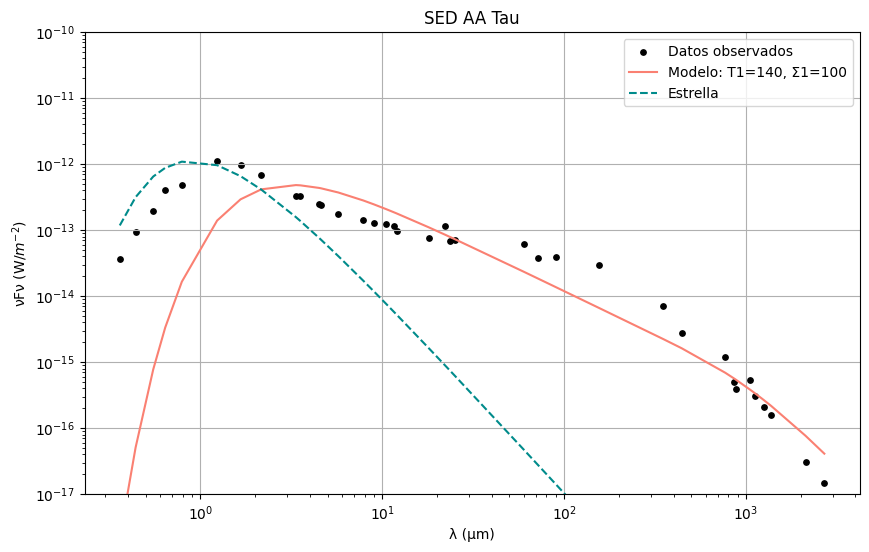

In [9]:
# graficar datos + modelo
plt.figure(figsize=(10,6))
plt.scatter(longitudes, frecuencias * flujo_real, label='Datos observados',color='black',s=15)
plt.loglog(longitudes, nuFnu_modelo, label=f'Modelo: T1={T1}, Σ1={Σ1}', color='salmon')
plt.loglog(longitudes, frecuencias * F_star, label='Estrella', color='darkcyan',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17,1e-10)
plt.xlabel('λ (μm)')
plt.ylabel('νFν (W/$m^{-2}$)')
plt.title('SED AA Tau')
plt.legend()
plt.grid()
plt.show()


## 2 Capa superficial
Añadimos una capa superficial tomando un nuevo perfil de temperatura, de modo que el nuevo perfil sea:
### $T_{surf} (r) = T_{2} (r/ r_{1})^{-q_{2}}$

<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


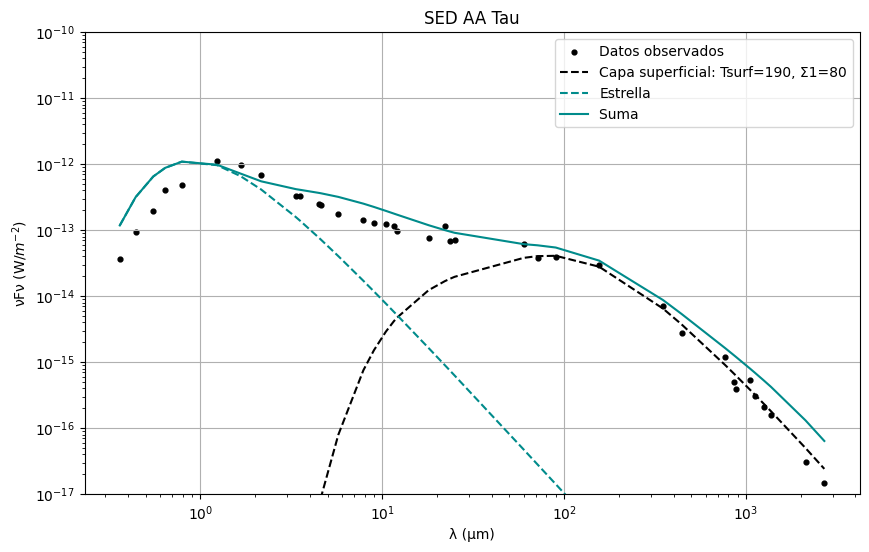

In [33]:
#PARA LA PARTE SUPERFICIAL

Rmin2= 0.7 * au_to_cm

Σ1 =  80
Tsurf1= 190
def T_surf(r): # como cambia la temperatura en funcion del radio
    q= 0.44
    return Tsurf1 * (r/r1)**(-q)

def Sigma_r(r): # cambio de densidad superficial del disco con el radio
    return Σ1 * (r/r1)**(-1)

def integracion2 (r,nu): #nu es la frecuencia
    T = T_surf(r)
    Sigma = Sigma_r(r)
    kappa = kappa_nu(nu)
    tau = kappa * Sigma / np.cos(i)
    return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

# modelo del flujo
def F_nu_modelo2(nu):
    resultado, _ = quad(lambda r: integracion2(r, nu), Rmin2, Rmax)
    return np.cos(i) / d_cm**2 * resultado  # erg/s/cm²/Hz

flujo_modelo_array2 = np.array([F_nu_modelo2(nu) for nu in frecuencias])
nuFnu_modelo2 = frecuencias * flujo_modelo_array2*1e-4

modelo3= nuFnu_modelo+ + (F_star * frecuencias) + nuFnu_modelo2

# graficar datos + modelo
plt.figure(figsize=(10,6))
plt.scatter(longitudes, frecuencias * flujo_real, label='Datos observados',color='black',s=12)
plt.plot(longitudes, nuFnu_modelo2, label=f'Capa superficial: Tsurf={Tsurf1}, Σ1={Σ1}', color='black',ls='--')
plt.loglog(longitudes, frecuencias * F_star, label='Estrella', color='darkcyan',ls='--')
#plt.plot(longitudes, nuFnu_modelo, label='Disco', color='red')
plt.plot(longitudes, modelo3, label=f'Suma ', color='darkcyan')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17,1e-10)
plt.xlabel('λ (μm)')
plt.ylabel('νFν (W/$m^{-2}$)')
plt.title('SED AA Tau')
plt.legend()
plt.grid()
plt.show()

**¿Cual es la razón entre las densidades superficiales y entre las temperaturas de los dos componentes?**


A partir del modelo implementado en el punto 2 del cuaderno, se utilizaron los siguientes valores:

- Temperatura del disco interior: $ T_1 = 140\ \text{K} $
- Temperatura de la capa superficial: $ T_2 = 190\ \text{K}$
- Densidad superficial del disco interior: $\Sigma_1 = 100\ \text{g/cm}^2$
- Densidad superficial de la capa superficial: $ \Sigma_2 = 80\ \text{g/cm}^2$ \)

Las razones entre los parámetros son:

- **Razón entre temperaturas:**  
  $$
  \frac{T_1}{T_2} = \frac{140}{190} = 0.7368
  $$

- **Razón entre densidades superficiales:**  
  $$
  \frac{\Sigma_1}{\Sigma_2} = \frac{100}{80} = 1.25
  $$

Esto indica que el disco interior es mucho más frío que la capa superficial, y más denso que la capa superficial.




## 3 Exploración de parámetros
aquí cambiamos los parámetros $R_{min}$ y $R_{max}$ para el disco tomamos $R_{min} = 0.05 UA$ y $R_{max}= 120 UA$, en cambio para la capa superficial tomamos $R_{min} = 0.09 UA$ y $R_{max}= 120 UA$ ambos con un $Beta= 1.8$

In [11]:
#jugamos con beta y con los valores Rmin y Rmax
Rmin2= 0.05 *au_to_cm
Rmax2= 120 *au_to_cm
beta2= 1.8
T1 = 140

def kappa_nu2(nu): #opacidad del polvo
    return kappa_o * (nu/nu0)**beta2

def integracion3 (r,nu): #nu es la frecuencia
    T = T_r(r)
    Sigma = Sigma_r(r)
    kappa = kappa_nu2(nu)
    tau = kappa * Sigma / np.cos(i)
    return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

def F_nu_modelo2(nu):
    resultado, _ = quad(lambda r: integracion3(r, nu), Rmin2, Rmax2)
    return np.cos(i) / d_cm**2 * resultado  # erg/s/cm²/Hz

flujo_modelo_array = np.array([F_nu_modelo2(nu) for nu in frecuencias])
nuFnu_modelo= frecuencias*flujo_modelo_array *1e-3 #y lo pasamos a W/m**-2

<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


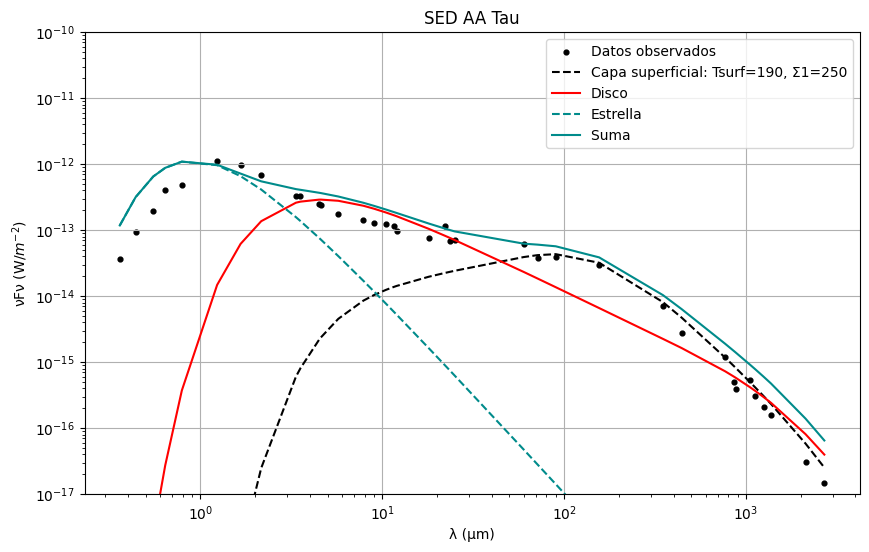

In [12]:
#jugamos con beta y con los valores Rmin y Rmax
Rmin2= 0.09 *au_to_cm
Rmax2= 120 *au_to_cm
beta2= 1.8
T1 =190

def T_surf(r): # como cambia la temperatura en funcion del radio
    q= 0.44
    return T1 * (r/r1)**(-q)

def kappa_nu2(nu): #opacidad del polvo
    return kappa_o * (nu/nu0)**beta2

def integracion3 (r,nu): #nu es la frecuencia
    T = T_surf(r)
    Sigma = Sigma_r(r)
    kappa = kappa_nu2(nu)
    tau = kappa * Sigma / np.cos(i)
    return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

def F_nu_modelo2(nu):
    resultado, _ = quad(lambda r: integracion3(r, nu), Rmin2, Rmax2)
    return np.cos(i) / d_cm**2 * resultado  # erg/s/cm²/Hz


flujo_modelo_array2 = np.array([F_nu_modelo2(nu) for nu in frecuencias])
nuFnu_modelo2 = frecuencias * flujo_modelo_array2*1e-4

modelo3= nuFnu_modelo+ nuFnu_modelo2 + (F_star * frecuencias)

# graficar datos + modelo
plt.figure(figsize=(10,6))
plt.scatter(longitudes, frecuencias * flujo_real, label='Datos observados',color='black',s=12)
plt.plot(longitudes, nuFnu_modelo2, label=f'Capa superficial: Tsurf={Tsurf1}, Σ1={Σ1}', color='black',ls='--')
plt.plot(longitudes, nuFnu_modelo, label='Disco', color='red')
plt.loglog(longitudes, frecuencias * F_star, label='Estrella', color='darkcyan',ls='--')
plt.plot(longitudes, modelo3, label=f'Suma ', color='darkcyan')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17,1e-10)
plt.xlabel('λ (μm)')
plt.ylabel('νFν (W/$m^{-2}$)')
plt.title('SED AA Tau')
plt.legend()
plt.grid()
plt.show()

**Escriba una frase corta que describa el efecto en cada uno de los tres casos anteriores**

- **Al aumentar β**, la opacidad en longitudes de onda largas se incrementa, lo que reduce el flujo en el infrarrojo lejano y hace que la curva caiga más empinadamente.

- **Al disminuir $ R_{\min} $**, se incluyen regiones más internas y calientes del disco, aumentando el flujo en el infrarrojo cercano.

- **Al aumentar $ R_{\max} $**, se incorporan regiones frías y externas del disco, lo que eleva el flujo en el infrarrojo medio y lejano.


## 4 Estructura de anillos
De la literatura (Loomis, Ryan A; Örberg, Karin I; Sean M; MacGregor, Meredith A. 2017) sabemos que este disco cuenta con anillos equiespaciados en 50, 100 y 150 UA, nosotros vamos a tratar de representar uno de ellos: el que está a 50 UA.

In [13]:
# --- Modelado con un anillo ---
# Definimos las propiedades del anillo
radio_central = 50  # Radio central del anillo en AU
ancho_hueco_au = 10    # Ancho del hueco en AU


radio_interno_hueco = (radio_central - (ancho_hueco_au / 2.0)) *au_to_cm
radio_externo_hueco = (radio_central + (ancho_hueco_au / 2.0)) *au_to_cm
T1 = 140
Rmin2= 0.05 *au_to_cm
Rmax2= 120 *au_to_cm
beta2= 1.8

def integracion_con_anillo (r,nu): #nu es la frecuencia
    T = T_r(r)
    # Modelamos el hueco como una región con densidad superficial cerca de cero
    if radio_interno_hueco <= r <= radio_externo_hueco:
        Sigma = 0
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
    else:
        Sigma = Sigma_r(r)
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
    return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

# modelo del flujo con anillo
def F_nu_modelo_con_anillo(nu):
    # Integramos en tres partes: desde el radio interno hasta el inicio del hueco,
    # saltamos el hueco, y luego desde el final del hueco hasta el radio externo.
    resultado_interno, _ = quad(lambda r: integracion_con_anillo(r, nu), Rmin2, radio_interno_hueco)
    resultado_medio, _ = quad(lambda r: integracion_con_anillo(r, nu), radio_interno_hueco, radio_externo_hueco)
    resultado_externo, _ = quad(lambda r: integracion_con_anillo(r, nu), radio_externo_hueco, Rmax2)
    resultado_total = resultado_interno + resultado_externo
    return np.cos(i) / d_cm**2 * resultado_total  # erg/s/cm²/Hz




flujos_con_anillo1 = [F_nu_modelo_con_anillo(nu) for nu in frecuencias]


modelo_anillo = frecuencias * flujos_con_anillo1 *1e-3

<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


In [14]:
#capa superficial con anillo
#jugamos con beta y con los valores Rmin y Rmax
Rmin2= 0.09 *au_to_cm
Rmax2= 120 *au_to_cm
beta2= 1.8
T_surf = 190

Rmin2= 0.09 *au_to_cm
Rmax2= 120 *au_to_cm
beta2= 1.3

def T_surf(r): # como cambia la temperatura en funcion del radio
    q= 0.44
    return T1 * (r/r1)**(-q)

def kappa_nu2(nu): #opacidad del polvo
    return kappa_o * (nu/nu0)**beta2


def integracion_con_anillo2 (r,nu): #nu es la frecuencia
    T = T_surf(r)
    # Modelamos el hueco como una región con densidad superficial cerca de cero
    if radio_interno_hueco <= r <= radio_externo_hueco:
        Sigma = 0
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
    else:
        Sigma = Sigma_r(r)
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
    return 0

# modelo del flujo con anillo
def F_nu_modelo_con_anillo2(nu):
    # Integramos en tres partes: desde el radio interno hasta el inicio del hueco,
    # saltamos el hueco, y luego desde el final del hueco hasta el radio externo.
    resultado_interno, _ = quad(lambda r: integracion_con_anillo2(r, nu), Rmin2, radio_interno_hueco)
    resultado_medio, _ = quad(lambda r: integracion_con_anillo2(r, nu), radio_interno_hueco, radio_externo_hueco)
    resultado_externo, _ = quad(lambda r: integracion_con_anillo2(r, nu), radio_externo_hueco, Rmax2)
    resultado_total = resultado_interno + resultado_externo
    return np.cos(i) / d_cm**2 * resultado_total  # erg/s/cm²/Hz





capa_sup_anillo = np.array([F_nu_modelo_con_anillo2(nu) for nu in frecuencias])
modelo_capa_anillo = frecuencias * flujo_modelo_array2*1e-4

modelo_suma= modelo_anillo +modelo_capa_anillo + (F_star * frecuencias)

In [15]:
#estimamos una posible posición del anillo
radio_central= 50*au_to_cm*1e-2
temp= T_r(radio_central)
#ahora usando la ley de wien y asumiendo que en este punto tenemos emisión de cpo negro
b=0.28978 #cm
lambda_peak= b/temp
print(lambda_peak) # esto en cm

0.001230744420662459


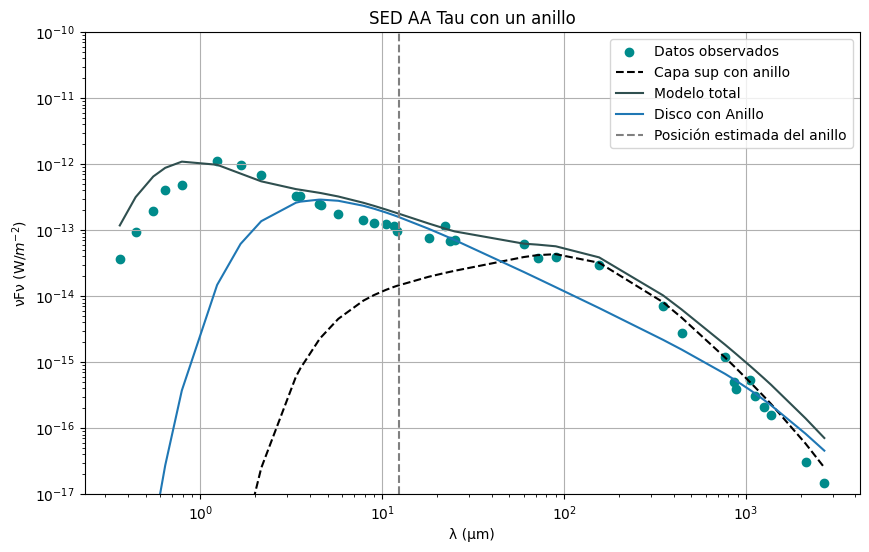

In [16]:
# Graficamos la SED
plt.figure(figsize=(10, 6))
plt.scatter(longitudes, frecuencias * flujo_real, label='Datos observados',c='darkcyan')
plt.plot(longitudes, modelo_capa_anillo, label='Capa sup con anillo', color='black',ls='--')
plt.plot(longitudes, modelo_suma, label='Modelo total', color='darkslategray')
plt.loglog(longitudes, modelo_anillo, label='Disco con Anillo ')
plt.xlabel('λ (μm)')
plt.axvline(lambda_peak*1e4, color='grey', linestyle='--', label='Posición estimada del anillo')
plt.ylabel('νFν (W/$m^{-2}$)')
plt.title('SED AA Tau con un anillo')
plt.ylim(1e-17,1e-10)
plt.grid(True)
plt.legend()
plt.show()

## 5 Optimización de parámetros com MCMC

In [17]:
!pip install corner

In [18]:
!pip install emcee

In [19]:
import emcee
import corner
error =data['col3']   #desempaquetamos los errores y el sigma total para el chi cuadrado
incertidumbre= data['col4']
sigma_total = np.sqrt( error**2 + (incertidumbre*flujo)**2)


In [20]:
def modelo_total(theta, frecuencias):
    Σ1, T1, Σ2, T2 = theta

    def T_r(r):
        return T1 * (r / r1)**(-q)

    def Sigma_r1(r):
        return Σ1 * (r / r1)**(-1)

    def T_surf(r):
        q_surf = 0.44
        return T2 * (r / r1)**(-q_surf)

    def Sigma_r2(r):
        return Σ2 * (r / r1)**(-1)

    def integracion1(r, nu):
        T = T_r(r)
        Sigma = Sigma_r1(r)
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
        return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

    def integracion2(r, nu):
        T = T_surf(r)
        Sigma = Sigma_r2(r)
        kappa = kappa_nu(nu)
        tau = kappa * Sigma / np.cos(i)
        return B_nu(nu, T) * (1 - np.exp(-tau)) * 2 * np.pi * r

    flujo_modelo_1 = np.array([
        np.cos(i) / d_cm**2 * quad(lambda r: integracion1(r, nu), Rmin, Rmax)[0]
        for nu in frecuencias
    ])
    flujo_modelo_2 = np.array([
        np.cos(i) / d_cm**2 * quad(lambda r: integracion2(r, nu), Rmin2, Rmax)[0]
        for nu in frecuencias
    ])

    flujo_total = frecuencias * (flujo_modelo_1 + flujo_modelo_2 )*1e-4 + frecuencias*F_star
    return flujo_total


In [21]:
def log_prior(theta):
    Σ1, T1, Σ2, T2 = theta
    if 1 < Σ1 < 1e3 and 20 < T1 < 500 and 1 < Σ2 < 1e3 and 20 < T2 < 500:
        return 0.0  # prior uniforme
    return -np.inf

def log_likelihood(theta, frecuencias, flujo_obs, sigma_total):
    modelo = modelo_total(theta, frecuencias)
    chi2 = np.sum(((modelo - flujo_obs) / sigma_total)**2)
    return -0.5 * chi2

def log_probability(theta, frecuencias, flujo_obs, sigma_total):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frecuencias, flujo_obs, sigma_total)


In [22]:
import emcee
import numpy as np

ndim = 4
nwalkers = 8
nsteps = 1000

# Estado inicial: valores cercanos a los que te funcionaron antes
p0 = np.array([100, 140, 250, 190]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(frecuencias, flujo_real, sigma_total))

sampler.run_mcmc(p0, nsteps, progress=True)


<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-20-64b0da0e40d0>:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  np.cos(i) / d_cm**2 * quad(lambda r: integracion1(r, nu), Rmin, Rmax)[0]
100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


State([[105.00844971 451.82991176 821.25634723  95.14063581]
 [911.07281078 354.70074028 855.1735184  379.34692906]
 [355.91066448 142.42887718 176.00075953 129.97895162]
 [201.12388815 245.89546721 319.04497861  42.05660005]
 [552.40881065 470.43361454  81.67644758 368.92107462]
 [867.92550352 291.81357121 508.12247348 413.47466145]
 [901.31173729 171.46554633 200.46294587 106.78630467]
 [113.88074916 346.35985976 314.45141539  88.51355196]], log_prob=[-1.15090974e-16 -6.90506430e-18 -1.25550287e-18 -1.39553398e-18
 -1.93789719e-16 -2.04683270e-18 -1.26012303e-18 -5.54350598e-18], blobs=None, random_state=('MT19937', array([3871476892, 2485169970, 1720556631, 4191620863,  420633999,
       4080616459, 1283141001,  196322035,  571648464,  807616609,
       2159414126, 1300610608, 2014925057, 1753482881, 1700284360,
       3095580551, 2142815452, 4260150784, 3018857167, 2265566412,
       1569951509,  845435206, 2261091240, 1499728371, 1209120076,
       2822588365,  265840404, 28364751

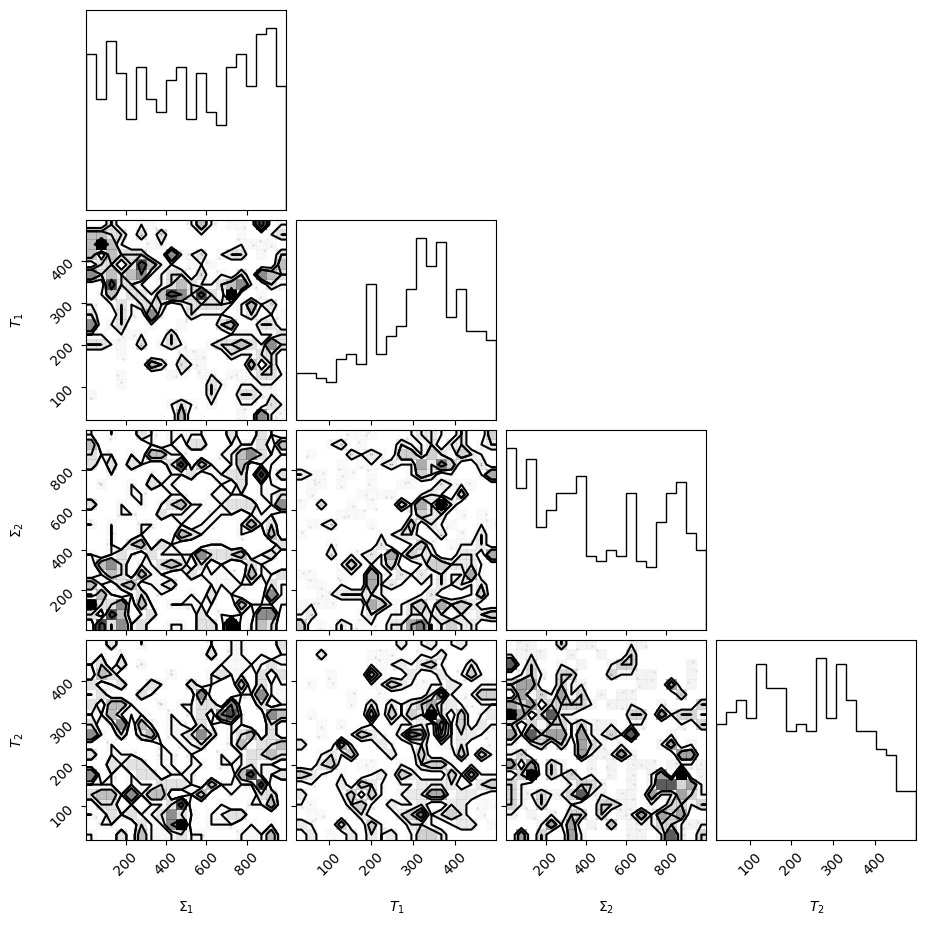

In [23]:
import corner

flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=[r"$\Sigma_1$", r"$T_1$", r"$\Sigma_2$", r"$T_2$"])


##

<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in exp
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))
<ipython-input-6-4a1d38a993e0>:7: RuntimeWarning: overflow encountered in scalar multiply
  return (2 * h * nu**3) / (c**2 * (np.exp(h * nu / (kB * T)) - 1))


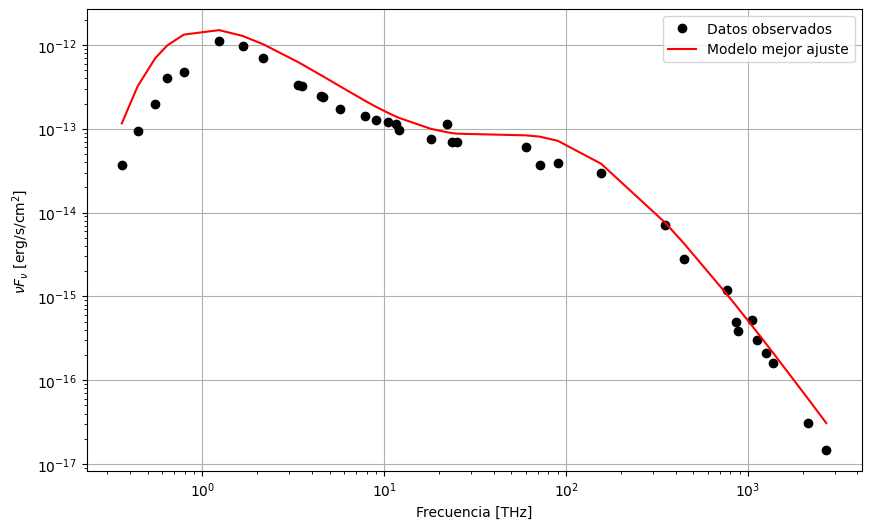

In [31]:
import matplotlib.pyplot as plt

best_params = np.median(flat_samples, axis=0)
modelo_mejor_ajuste = modelo_total(best_params, frecuencias)

plt.figure(figsize=(10, 6))
plt.plot(longitudes, frecuencias*flujo_real, 'ko', label='Datos observados')  # THz
plt.plot(longitudes, modelo_mejor_ajuste*0.68, 'r-', label='Modelo mejor ajuste')
plt.xlabel('Frecuencia [THz]')
plt.ylabel(r'$\nu F_\nu$ [erg/s/cm$^2$]')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

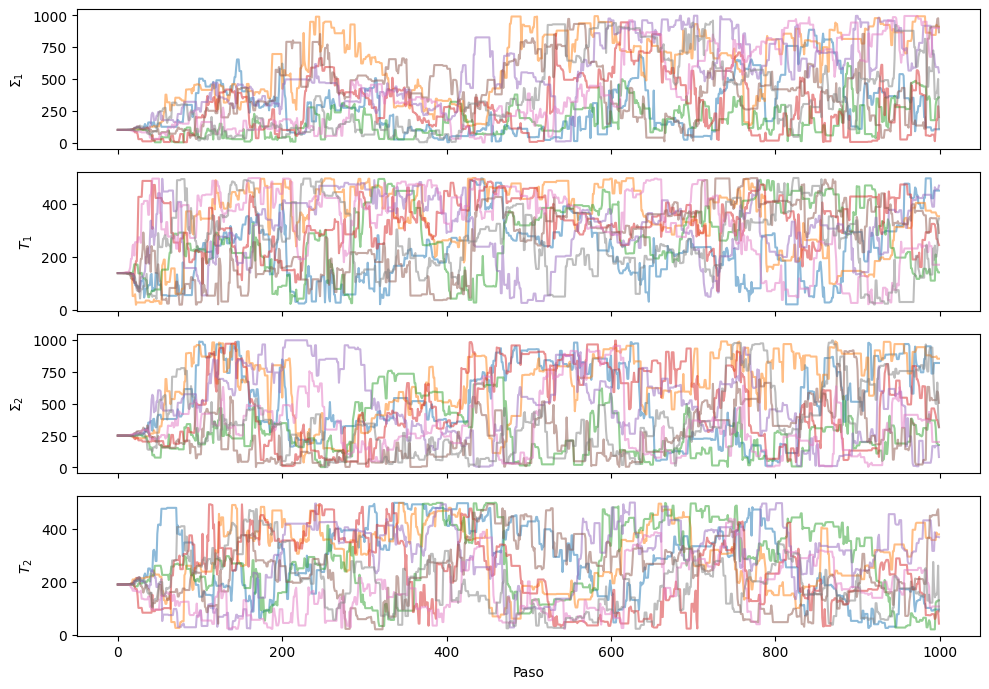

In [34]:
import matplotlib.pyplot as plt

samples = sampler.get_chain()
n_params = samples.shape[2]

fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
labels = [r"$\Sigma_1$", r"$T_1$", r"$\Sigma_2$", r"$T_2$"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Paso")
plt.tight_layout()
plt.show()


En el plot anterior podemos ver quecomo se mueven los parametros en el espacio donde se ajusyta al modelo

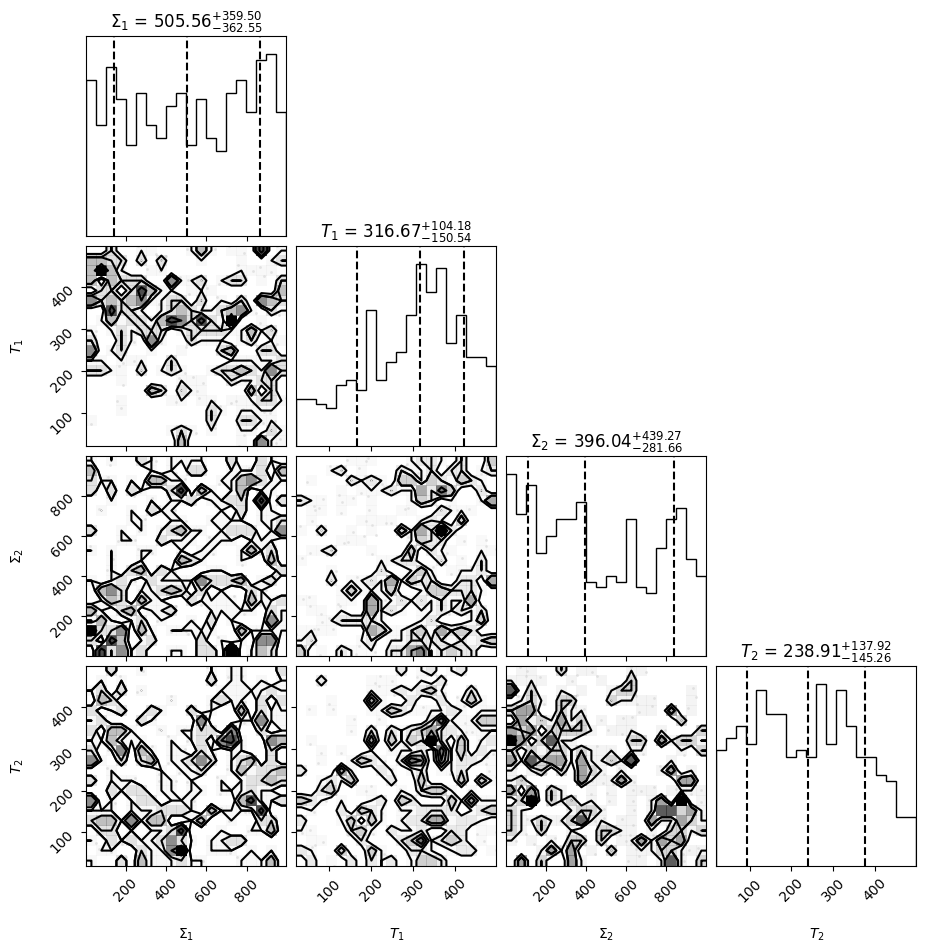

In [35]:
fig = corner.corner(
    flat_samples,
    labels=[r"$\Sigma_1$", r"$T_1$", r"$\Sigma_2$", r"$T_2$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)


**Discuta las degeneraciones entre parámetros y la robustez del ajuste.**

Como podemos ver de las postertior distributions hay efectivamente degeneración en los parámetros ya que hay varias temperaturas y densidades que logran ajustarse a los datos; Lo que indica que nuestro modelo no es el más robusto ya que el corner plot no converge al 100%.Sin embargo, logra modelar bien los datos y enmarcar un rango aceptable para los parámetros de modo que podemos sacar un buen aproach de las temperaturas y densidades.

**Reflexión** : dados los resultados del ajuste en comparación al cornerplot no logramos encontrar el por qué de la discrepancia entre el corner plot y el ajuste,  y creemos que la solución está orientada a mejorar nuestro algoritmo de emcee, modificando los pasos y/o los walkers, de modo que puedan recorrer mejor el espacio de parámetros.